In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/features_30_sec.csv')

In [3]:
# Identify Features and Target Label
y = data['label']
X = data.drop(columns = ['label','filename','length'])


In [4]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test = split(X, y)


X_dev shape: (800, 57)
X_test shape: (200, 57)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [5]:
model_bg = GradientBoostingClassifier()
model_bg.fit(X_dev, y_dev)
predsDevbg = model_bg.predict(X_dev)
predsTestbg = model_bg.predict(X_test)

In [6]:
testbg_score =  accuracy_score(y_test, predsTestbg )
devbg_score = accuracy_score(y_dev, predsDevbg )

In [7]:
print("Classification Score for Gradient Boosting Classifier on Dev dataset:\n")
print("Dev Score : ", devbg_score)
print(classification_report(y_dev, predsDevbg ))
print("--------------------------------------------------------")
print("Classification Score for Gradient Boosting Classifier on Test dataset:\n")
print("Test Score :", testbg_score)
print(classification_report(y_test, predsTestbg ))

Classification Score for Gradient Boosting Classifier on Dev dataset:

Dev Score :  0.99875
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00        88
   classical       1.00      1.00      1.00        84
     country       1.00      1.00      1.00        78
       disco       1.00      1.00      1.00        78
      hiphop       1.00      1.00      1.00        81
        jazz       1.00      1.00      1.00        71
       metal       0.99      1.00      0.99        81
         pop       1.00      1.00      1.00        84
      reggae       1.00      1.00      1.00        78
        rock       1.00      0.99      0.99        77

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

--------------------------------------------------------
Classification Score for Gradient Boosting Classifier on Test dataset:

Test Score : 0.75
  

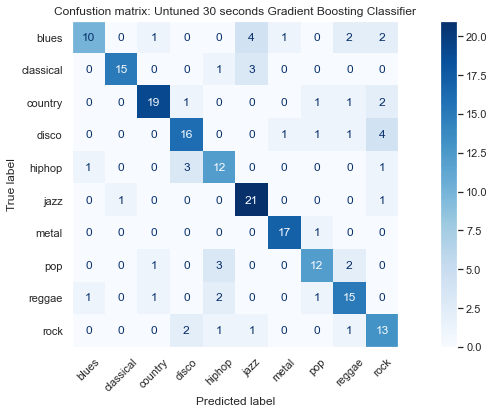

Accuracy : 0.75
Macro F-1 Score : 0.75


In [8]:
# Evaluate Model on Test set
class_labels = list(model_bg.classes_)
macro_f1, accuracy = evaluate_model(predsTestbg , y_test, class_labels,
                                    'Confustion matrix: Untuned 30 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:
parameters = {"n_estimators": [100],
             "learning_rate": [0.1],
             "max_depth": random.sample(range(3, 8), 2)}
print(parameters)

{'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [7, 5]}


In [10]:
tune_bg = GridSearchCV(estimator = model_bg , param_grid = parameters, cv = 5)
tune_bg.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1], 'max_depth': [7, 5],
                         'n_estimators': [100]})

In [11]:
print("Best Score :", tune_bg.best_score_)
print("Best Parameters :",tune_bg.best_params_)

Best Score : 0.675
Best Parameters : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [12]:
predsDevbg_tuned = tune_bg.predict(X_dev)
predsTestbg_tuned = tune_bg.predict(X_test)

print("Score on Dev data for GB using GridSearchCV:", accuracy_score(y_dev, predsDevbg_tuned))
print("Score on Test data for GB using GridSearchCV:",accuracy_score(y_test, predsTestbg_tuned))

Score on Dev data for GB using GridSearchCV: 0.99875
Score on Test data for GB using GridSearchCV: 0.72


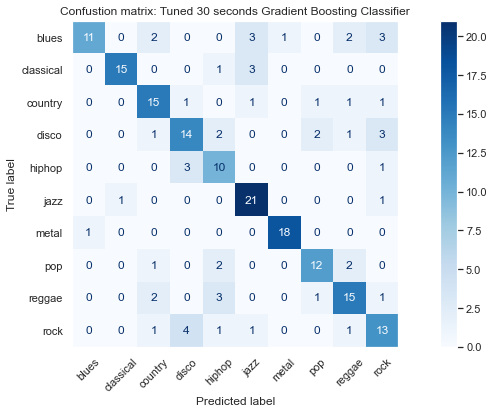

Accuracy : 0.72
Macro F-1 Score : 0.72


In [13]:
# Evaluate Model on Test set
class_labels = list(model_bg.classes_)
macro_f1, accuracy = evaluate_model(predsTestbg_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 30 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [14]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.27766419 0.24831461 0.10817539 0.0735775  0.05921353 0.04313114
 0.03041835 0.02485929 0.02357102 0.0185913  0.01458576 0.01445453
 0.01236632 0.01085372 0.01042907 0.00964277 0.00916214 0.00839634
 0.00793393 0.00728803 0.00723336 0.00675793 0.00606153 0.00560783
 0.00551638 0.0051258  0.00504983 0.00465476 0.00454157 0.00424036]
Sum of Explained Variance: 0.9554651510716244


In [15]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209189,-0.328531,0.078993,-0.157339,...,0.038493,-0.013059,0.079152,0.043046,-0.018157,0.030879,0.073384,0.068223,0.005496,blues
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098223,-0.077304,0.046260,-0.040616,0.094599,...,-0.046175,-0.069766,-0.014199,0.047300,0.033735,0.010047,0.052736,0.012723,-0.019821,rock
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066610,-0.197729,0.041884,0.013268,...,0.035513,0.009699,-0.059808,-0.158230,-0.007220,0.115889,0.032417,-0.000584,-0.030732,reggae
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091608,0.131251,-0.044357,0.123934,...,0.002498,-0.001698,-0.014629,0.033832,-0.035342,0.015778,0.002242,0.020332,-0.022350,rock
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025042,-0.233481,0.295027,0.131576,...,-0.082208,0.056460,-0.017634,-0.018166,-0.001680,-0.048571,-0.032418,-0.021599,0.014291,reggae


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [16]:
model_pca = GradientBoostingClassifier()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainbg = model_pca.predict(pca_data)
pcaTestbg = model_pca.predict(pca_data_test)

In [17]:
pcatestbg_score =  accuracy_score(y_test, pcaTestbg )
pcabg_score = accuracy_score(y_dev, pcaTrainbg )

In [18]:
print("Classification Score for Gradient Boosting Classifier on Train dataset:\n")
print("Train Score : ", pcabg_score)
print("--------------------------------------------------------")
print("Classification Score for Gradient Boosting Classifier on Test dataset:\n")
print("Test Score :", pcatestbg_score)

Classification Score for Gradient Boosting Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for Gradient Boosting Classifier on Test dataset:

Test Score : 0.695


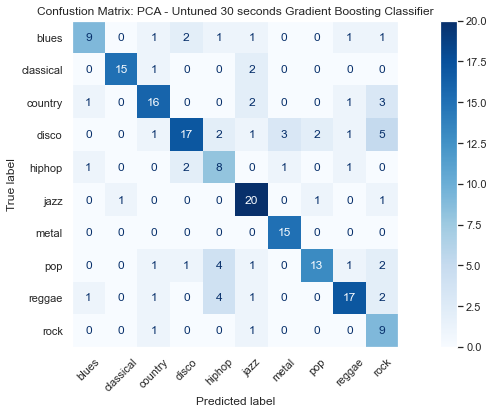

Accuracy : 0.69
Macro F-1 Score : 0.69


In [19]:
# Evaluate Model
class_labels = list(model_bg.classes_)
macro_f1, accuracy = evaluate_model(pcaTestbg , y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 30 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [20]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209189,-0.328531,0.078993,-0.157339,...,0.041188,0.038493,-0.013059,0.079152,0.043046,-0.018157,0.030879,0.073384,0.068223,0.005496
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098223,-0.077304,0.046260,-0.040616,0.094599,...,-0.041836,-0.046175,-0.069766,-0.014199,0.047300,0.033735,0.010047,0.052736,0.012723,-0.019821
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066610,-0.197729,0.041884,0.013268,...,0.088261,0.035513,0.009699,-0.059808,-0.158230,-0.007220,0.115889,0.032417,-0.000584,-0.030732
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091608,0.131251,-0.044357,0.123934,...,-0.015504,0.002498,-0.001698,-0.014629,0.033832,-0.035342,0.015778,0.002242,0.020332,-0.022350
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025042,-0.233481,0.295027,0.131576,...,0.016560,-0.082208,0.056460,-0.017634,-0.018166,-0.001680,-0.048571,-0.032418,-0.021599,0.014291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.565572,0.422083,0.328459,0.111136,-0.153392,-0.133144,0.121272,0.170830,0.181531,-0.003556,...,0.293859,-0.012801,0.058186,0.046986,0.083177,-0.065853,0.017132,-0.026112,-0.001661,0.006182
796,0.258810,-0.934083,0.031836,0.495334,0.077338,-0.114134,0.171019,-0.128295,0.103756,0.171795,...,0.029130,-0.006334,-0.039541,0.058086,0.157357,0.041660,-0.130056,-0.039514,0.104398,0.003399
797,1.243638,0.799851,0.648936,0.304699,-0.379732,0.291342,-0.171434,-0.020329,0.029576,-0.338991,...,-0.005537,-0.005068,0.014829,-0.003623,0.054871,-0.004664,-0.060047,-0.100529,-0.037958,0.007359
798,0.251711,0.398993,-0.418890,-0.045822,0.030828,0.140384,-0.063128,-0.085615,-0.096348,0.127775,...,0.080195,-0.049245,0.015888,-0.003139,-0.024538,0.122549,-0.098229,-0.052454,0.023884,-0.103086


In [21]:
model_pca_tuned = tune_bg 
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainbg_tuned = model_pca_tuned.predict(pca_data)
pcaTestbg_tuned = model_pca_tuned.predict(pca_data_test)

In [22]:
pcatestbg_score =  accuracy_score(y_test, pcaTestbg )
pcabg_score = accuracy_score(y_dev, pcaTrainbg )

In [23]:
print("Classification Score for GradientBoostingClassifier on Train dataset:\n")
print("Train Score : ", pcabg_score)
print("--------------------------------------------------------")
print("Classification Score for GradientBoostingClassifier on Test dataset:\n")
print("Test Score :", pcatestbg_score)

Classification Score for GradientBoostingClassifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for GradientBoostingClassifier on Test dataset:

Test Score : 0.695


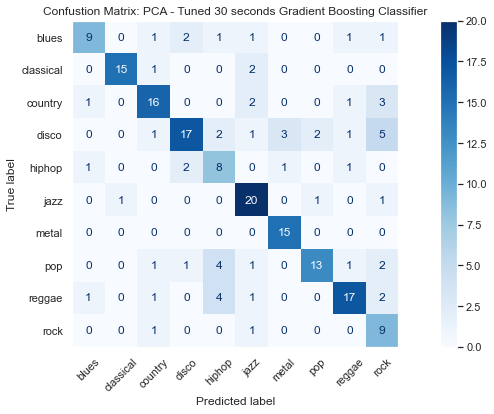

Accuracy : 0.69
Macro F-1 Score : 0.69


In [24]:
# Evaluate Model
class_labels = list(model_bg.classes_)
macro_f1, accuracy = evaluate_model(pcaTestbg , y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 30 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)